# CPSC 533R Visual AI - Assignment 1

In [16]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Use standard FashionMNIST dataset
def gray_to_color(x):
    return x.repeat(3, 1, 1)

## Assignment 1-3: Data handling

In [17]:
class wrappedMinistDataset:
    
    def __init__(self, root, train, download, transform):
        self.mnistDataset = torchvision.datasets.MNIST(
                                root = root,
                                train = train,
                                download = download,
                                transform = transform
                            )
        
    def __getitem__(self, index):
        img, label = self.mnistDataset.__getitem__(index)
        return {"img": img, "class": label}
    
    def __len__(self):
        return self.mnistDataset.__len__()

class modelRes18(nn.Module):
    def __init__(self, num_classes=10):
        super(modelRes18, self).__init__()
        self.backbone = torchvision.models.resnet18(num_classes=num_classes)
    
    def forward(self, input_dict):
        tensor = input_dict["img"]
        preds = self.backbone(tensor)
        return {"class": preds}

def train_process(model, train_set, batch_size=32, cuda=True):
    loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, num_workers=0)
    iterator = iter(loader)
    losses = []
    if cuda:
        model = model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    for i in range(200): #range(len(loader)):
        batch = next(iterator)
        if cuda:
            for k, v in batch.items():
                batch[k] = v.cuda()
        preds = model(batch)
        loss = nn.functional.cross_entropy(preds["class"], batch["class"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i%20==0:
            print(i,losses[-1])
    plt.plot(losses)

0 2.2914199829101562
20 1.9509154558181763
40 1.8185781240463257
60 1.410296082496643
80 1.1334707736968994
100 0.9654350876808167
120 0.8413479924201965
140 0.8992843627929688
160 0.801120936870575
180 0.6232799291610718


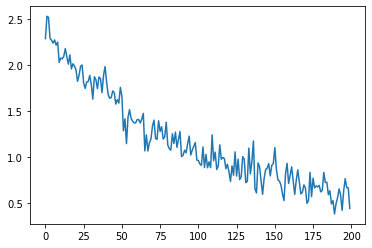

In [18]:
train_set = wrappedMinistDataset(
    root = './DatasetMNIST',
    train = True,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
model = modelRes18(num_classes=10).cuda()
train_process(model, train_set)

## Assignment4-10

In [22]:
# Task 4 here
class pairWiseMinistDataset:
    def __init__(self, root, train, download, transform):
        self.mnistDataset = torchvision.datasets.MNIST(
                                root = root,
                                train = train,
                                download = download,
                                transform = transform
                            )
        self.mnist_size = self.mnistDataset.__len__()
        
    def __getitem__(self, index):
        index1 = index // self.mnist_size
        index2 = index % self.mnist_size
        img1, label1 = self.mnistDataset.__getitem__(index1)
        img2, label2 = self.mnistDataset.__getitem__(index2)
        label = 1. if label1 == label2 else 0.
        return {"img1": img1, "img2": img2, "class": label}
    
    def __len__(self):
        return self.mnist_size * self.mnist_size

# Taks7 TODO:  Validation subset
    
# Task 5 here
class pairWiseModel(nn.Module):
    def __init__(self, backbone = torchvision.models.resnet18, num_embedding = 256):
        super(pairWiseModel, self).__init__()
        self.backbone = backbone(num_classes=num_embedding)
        self.classifier = nn.Linear(num_embedding*2, 1)
    
    def forward(self, input_dict):
        img1 = input_dict["img1"]
        img2 = input_dict["img2"]
        feature_img1 = self.backbone(img1)
        feature_img2 = self.backbone(img2)
        stacked_feature = torch.cat([feature_img1, feature_img2], dim=1)
        preds = self.classifier(stacked_feature).squeeze()
        return {"class": preds}

In [29]:
LOG_CYCLE = 20
VALIDATION_CYCLE = 50
#Alright I'll check it out 
# @Atabak: Can probably do vis in this function
def train_process_with_vis(model, train_set, val_set, batch_size=32, cuda=True):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=0)
    train_iter = iter(train_loader)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=0)
    val_iter = iter(val_loader)

    losses = []
    if cuda:
        model = model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    for i in range(200): #range(len(loader)):
        # Training 
        # Preaparing Data
        batch = next(train_iter)
        if cuda:
            for k, v in batch.items():
                batch[k] = v.cuda()
        # Forward model
        preds = model(batch)
        # Task 6 here, more losses to be try out
        loss = nn.functional.binary_cross_entropy_with_logits(preds["class"], batch["class"])
        # Backprop and Update Prams
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging 
        losses.append(loss.item())
        if i % LOG_CYCLE == 0:
            print(i,losses[-1])
            
        if i % VALIDATION_CYCLE == 0:
            # Taks7 TODO:  DO Validation here
            pass
    
    # Task 8,9,10 TODO: visualize here
    plt.plot(losses)

0 0.6812441839720123
20 0.504157499410212
40 0.36866166605614126
60 0.3066067195031792
80 0.28405270774965174
100 0.3415504446311388
120 0.26483324138098396
140 0.2105147840338759
160 0.344395231542876
180 0.2577346095495159


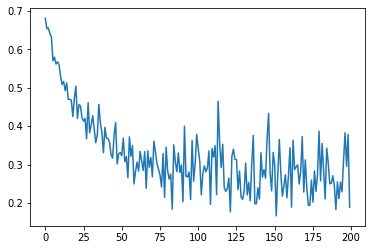

In [30]:
train_set = pairWiseMinistDataset(
    root = './DatasetMNIST',
    train = True,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
test_set = pairWiseMinistDataset(
    root = './DatasetMNIST',
    train = False,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
# Task 7 TODO: validation set
model = pairWiseModel(backbone=torchvision.models.resnet18, num_embedding=256)
# @Atabak replace val_set=test_set here, just for convenience now
train_process_with_vis(model, train_set, val_set=test_set, batch_size=64, cuda=True)